# Sedaro Rendezous Tutorial Notebook 
Demonstrates using the Sedaro API  to calculate Hohmann Rendezous manevuers between two satelite using a Jupyter notebook.

1. Manuever 1: Start a Hohmann transfer to raise the orbit of the chaser satelite to the same altitude as the target satelite.
2. Manuever 2: Complete the Hohmann transfer to match the velocity of the target satelite.
3. Manuever 3: Engage the Richard WARAT (Wicked Awesome Rendezous Approach Thrust) algorithm 

In [1]:
import sedaro
import math
import yaml
import json
import matplotlib.pyplot as plt
import hohmann_utils as hohmann

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Important: Read Before Running

This notebook makes changes to agent and scenario branches indicated in the settings section. Ensure any changes to the target branches are saved prior to running this code. Sedaro recommends committing current changes and creating new branches in the target repositories to avoid loss of work.

This notebook also requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the same directory as this notebook with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been compromised, you can revoke it in the user settings interface on the Sedaro website.

## Sedaro python client setup
Note: More information about the sedaro-python client can be found here: [https://github.com/sedaro/sedaro-python]


In the next cell, adjust the following variables as needed
- *Sedaro_api_host*
- *Sedaro_api_token*

In [2]:
Sedaro_api_host  = "https://api.astage.sedaro.com" # " "http://localhost:80" # "api.sedaro.com"

# Set your API token value either directly or via loading a secrets file
# !! NOTE !!  Be careful not to check in your API Key into a source control repo  !! Note !!
secretPath = '/Users/sedaro/Documents/sedaro/sedaro-satellite/secrets.json'
with open(secretPath, 'r') as file:
    Sedaro_api_token = json.load(file)['Alpha_API_key']
    
sedaroAPI = sedaro.SedaroApiClient(api_key=Sedaro_api_token, host=Sedaro_api_host)

Resources:
- Fundamentals of Astrodynamics 1971 (Bate, Mueller, White) pg 163, 362
- Fundamentals of Astrodynamics and Applications Fifth Edition 2022 (Vallado) pg 329, 367
 

In [3]:
# helper constants
Earth_radius_km = 6378.1363
earth_u_ER = 1
sec_per_TU = 806.811


Orbits based on the Vanguard 1 TLE but made circular

In [4]:

# orbits 
# TLE - 20Mar2024 from https://celestrak.org/NORAD/elements/gp.php?CATNR=5
# VANGUARD 1              
# 1 00005U 58002B   24078.99142898  .00000601  00000+0  79998-3 0  9992
# 2 00005  34.2449 325.2683 1840098  41.3159 331.2952 10.85238290354123

    


In [5]:
# get the inputs we need to calculate the hohmann transfer
# 1. the current position of the chaser satellite
# 2. the current position of the target satellite


workspace_id = "PLtYYcbJgKLbL8bcWbPG62"

scenario_branch_id = "PLtYcxShg3qwn87bVn4nv7"
scenario_branch = sedaroAPI.scenario(scenario_branch_id)

chaser_agent_branch_id = "PLtYdbNnDYHRXhZRphdr6k"
chaser_agent_branch = sedaroAPI.agent_template(chaser_agent_branch_id)

target_agent_branch_id = "PLtYdJg3f28MDqp3Jn5GRw"
target_agent_branch = sedaroAPI.agent_template(target_agent_branch_id)


# Define the agents and its orbit
Use vanguard OE as a basis for the two coplaner circular orbits

In [25]:
chaser_radius_km = 7000.0
target_radius_km = 10000.0
circuliar_eccentricity = 0.0
inclination_deg = 34.2449 # vanguard
raan_deg = 325.2683 # vanguard
argument_of_latitude_deg = 331 # vanguard

Delete Existing agent and orbits

In [94]:

# delete_existing:
agent_ids = [entry.id for entry in scenario_branch.Agent.get_all()]
orbit_ids = [entry.id for entry in scenario_branch.Orbit.get_all()]
if len(agent_ids) + len(orbit_ids) > 0:
    scenario_branch.crud(delete=(agent_ids + orbit_ids))


create the agents and assign orbits

In [95]:
chaser_orbit = dict(
        type='PropagatedOrbitKinematics',
        initialStateDefType='ORBITAL_ELEMENTS',
        initialStateDefParams={
            'a': chaser_radius_km,
            'e': circuliar_eccentricity,
            'inc': inclination_deg,
            'raan': raan_deg,
            'om': 0.0,
            'nu': argument_of_latitude_deg
        }
    )


target_orbit = dict(   
        type='PropagatedOrbitKinematics',
        initialStateDefType='ORBITAL_ELEMENTS',
        initialStateDefParams={
            'a': target_radius_km,
            'e': circuliar_eccentricity,
            'inc': inclination_deg,
            'raan': raan_deg,
            'om': 0.0,
            'nu': argument_of_latitude_deg
        }
    )
 

In [96]:

orbits = [chaser_orbit, target_orbit]
result = scenario_branch.crud(blocks=orbits)
orbit_ids = result['crud']['blocks']


In [97]:
   
chaser_agent = dict(
        type='TemplatedAgent',
        name=f'Chaser',
        templateRef = chaser_agent_branch_id
    )
target_agent = dict(
        type='TemplatedAgent',
        name=f'Target',
        templateRef = target_agent_branch_id
    )


In [98]:

agents = [chaser_agent, target_agent]
for orbit_id, agent in zip(orbit_ids, agents):
    agent['kinematics'] = orbit_id
result = scenario_branch.crud(blocks=agents)
agent_ids = result['crud']['blocks']


In [99]:

chaser_agent_id = agent_ids[0]
target_agent_id = agent_ids[1]
chaser_agent_id, target_agent_id

('PLxJwpyLdr7FdzzD6SHHB4', 'PLxJwpyNdz2y29TXxc7YGj')

Calc the two hohmann manuever times and delta V

In [100]:

target_position = target_radius_km
chaser_position = chaser_radius_km
phase_angle_deg = -80.0 # setup the orbital elements to make this true at start of the simulation 

Convert to ER units

In [101]:
# convert the radii to canonical units
a_chaser_ER = hohmann.calc_radaii_canonical_units(chaser_radius_km)
a_target_ER = hohmann.calc_radaii_canonical_units(target_radius_km) 
a_chaser_ER, a_target_ER

(1.0974992804716324, 1.567856114959475)

Calculate the wait time till the first transfer orbit burn 

In [102]:
wait_seconds_to_dv1 = hohmann.calc_hohmann_transfer_wait_time(a_chaser_ER, a_target_ER, phase_angle_deg, k=1)*sec_per_TU
wait_seconds_to_dv1

12462.670392296208

and how long until dv2

In [103]:
transfer_orbit_time_dv1_to_dv2_secs =hohmann.calc_hohmann_transfer_time(a_chaser_ER, a_target_ER)*sec_per_TU
transfer_orbit_time_dv1_to_dv2_secs

3899.504072553566

and the actual delta V burn amounts

In [104]:
dv_start, dv_end = hohmann.calc_hohmann_transfer_dvs(a_chaser_ER, a_target_ER)
total_delta_v_ERperTU = dv_start + dv_end 
dv_start *= Earth_radius_km/sec_per_TU
dv_end *= Earth_radius_km/sec_per_TU
total_delta = dv_start + dv_end

dv_start, dv_end, total_delta

(0.6387906775042261, 0.5840903571011151, 1.2228810346053414)

Set the first impulsive burn along the velocity vector to enter transfer orbit
chaser_agent_branch

In [105]:
chase_first_dv = dict(
    type='ImpulsiveDeltaVAlgorithm',
    name="Delta V1 @ T1",
    #agent=chaser_agent_id,
    epoch={'s':wait_seconds_to_dv1},
    delta=[0, dv_start, 0]
)

chase_second_dv = dict(
    type='ImpulsiveDeltaVAlgorithm',
    name="Delta V2 @ T2",
    #agent=chaser_agent_id,
    epoch={'s':wait_seconds_to_dv1 + transfer_orbit_time_dv1_to_dv2_secs},
    delta=[0, dv_end, 0]
)

First delete existing Burns

In [106]:
burn_ids = [entry.id for entry in chaser_agent_branch.ImpulsiveDeltaVAlgorithm.get_all()]
if len(burn_ids) > 0:
    chaser_agent_branch.crud(delete=(burn_ids))

In [107]:
burns = [chase_first_dv, chase_second_dv]
result = chaser_agent_branch.crud(blocks=burns)


In [108]:

burn_ids = result['crud']['blocks']
burn_ids

['PLxBzFxMZ3FKVvCBtTH6C5',
 'PLxC4NqXlgXjkdKyzp82Mb',
 'PLxJx3SPMqCNHjB7LghmGw',
 'PLxJx3SRPwQWtggfTMyR5V']

Run the Sim

In [109]:
sim = scenario_branch.simulation
# Start scenario
sim.start()

# Wait for it to finish, then get results
results = sim.results_poll()

# Summarize results
results.summarize()

Downloading...: 100%|██████████[00:01<00:00]

---------------------------------------------------------------------------
                      Sedaro Simulation Result Summary                     
---------------------------------------------------------------------------
✅ Simulation succeeded after 36.0s

🛰️ Templated Agents 
    • Chaser
    • Target
---------------------------------------------------------------------------
❓ Query agent results with .agent(<NAME>)


Load results and analyse

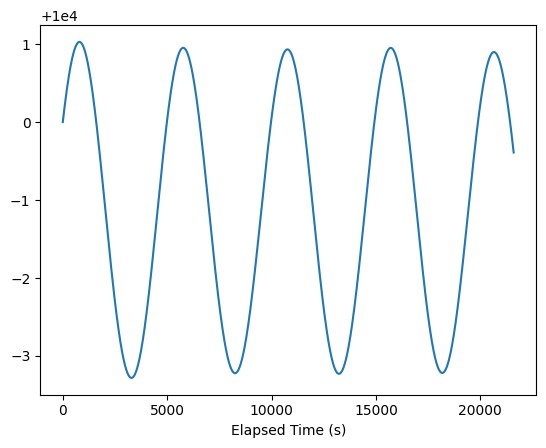

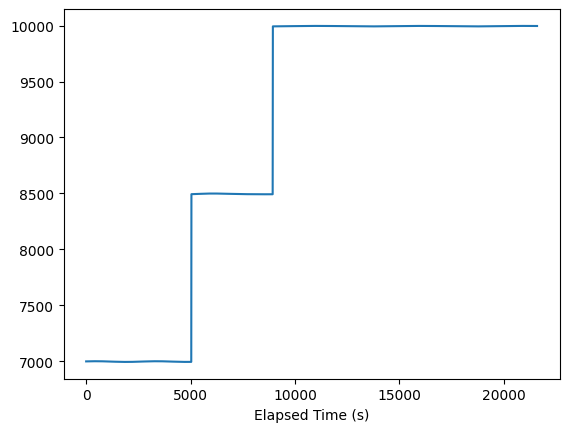

In [42]:
results.agent('Target').block('YddJw9jfT-IveoP86XQjA').orbitalElements.a.plot()
results.agent('Chaser').block('YddJw9jfT-IveoP86XQjA').orbitalElements.a.plot()

Cleanup

In [43]:
# Delete created Agents and Orbits
scenario_branch.crud(delete=agent_ids + orbit_ids)

{'branch': {'createdBy': {'dateCreated': '2023-06-08T17:41:05.537Z',
   'dateModified': '2024-03-21T15:02:40.796Z',
   'email': 'paul.greene@sedarotech.com',
   'externalIdentityProvider': None,
   'firstName': 'Sonic',
   'id': 'NXR5FETRfiDHSmbBzNsjV',
   'incomplete': False,
   'isFlagged': False,
   'isVerified': True,
   'lastName': 'Boom',
   'organization': 'Sedaro-Shadaloo',
   'organizationCountryCode': 'US',
   'roles': ['NXLSDqnSpDLuAxadnqxmV',
    'NXR63t-RtPcPebUNUYbjF',
    'PK558r6H7HtF69TX7YbCPn',
    'PKR7mqQnZLdPf3nrLdJkt5',
    'PLbs6P4FSjsS9CdKx3wHpK',
    'PLcKpz3M7WnrjxXSlmHXgn',
    'PLnYljKZgX2FfY9CLpJXkc',
    'PLtYYg3b94tsSGNS3w9RSz'],
   'userCountryCode': 'US',
   'workspaces': ['PLtYYcbJgKLbL8bcWbPG62',
    'NXLSDXzUwajLVTowmvkWF',
    'PK558qCtkYLzl95F2chm7l',
    'NXR63adT3mfg9vFHPzCyF',
    'PKR7mpLvpLGPp77y5N4yjx',
    'PLnYlg7QLd9Z4TGPLms2zf',
    'PLcKpwtb4ypwPn5GD4V28w',
    'PLbs6LmBw4lDfqGTwJkhNZ']},
  'data': {'_blockNames': ['AgentGroup',
    'Aux

In [44]:
# delete the Maneuvers
burn_ids = [entry.id for entry in chaser_agent_branch.ImpulsiveDeltaVAlgorithm.get_all()]
if len(burn_ids) > 0:
    chaser_agent_branch.crud(delete=(burn_ids))